In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib
from textwrap import fill
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz

import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting
from config import run_config

import simplekml

pd.options.mode.chained_assignment = None

#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/atmos_column/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [19]:
figures_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/'
pickle_data_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/'

# Full EM27 Data Figure

In [4]:
#Loading the full dataset can take a while

em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"

dt1_str = '2022-05-23 00:00:00'
dt2_str =  '2023-05-01 00:00:00'
tz = 'US/Mountain'

oof_manage = ac.oof_manager(em27_data_folder,tz)
flag0_em27_df = oof_manage.load_oof_df_inrange(dt1_str,dt2_str,True)

In [5]:
em27_resample_interval = '5T'

if em27_resample_interval == None:
    em27_resampled = flag0_em27_df.copy()
else:
    em27_resampled = flag0_em27_df.resample(em27_resample_interval).mean(numeric_only=True).dropna()

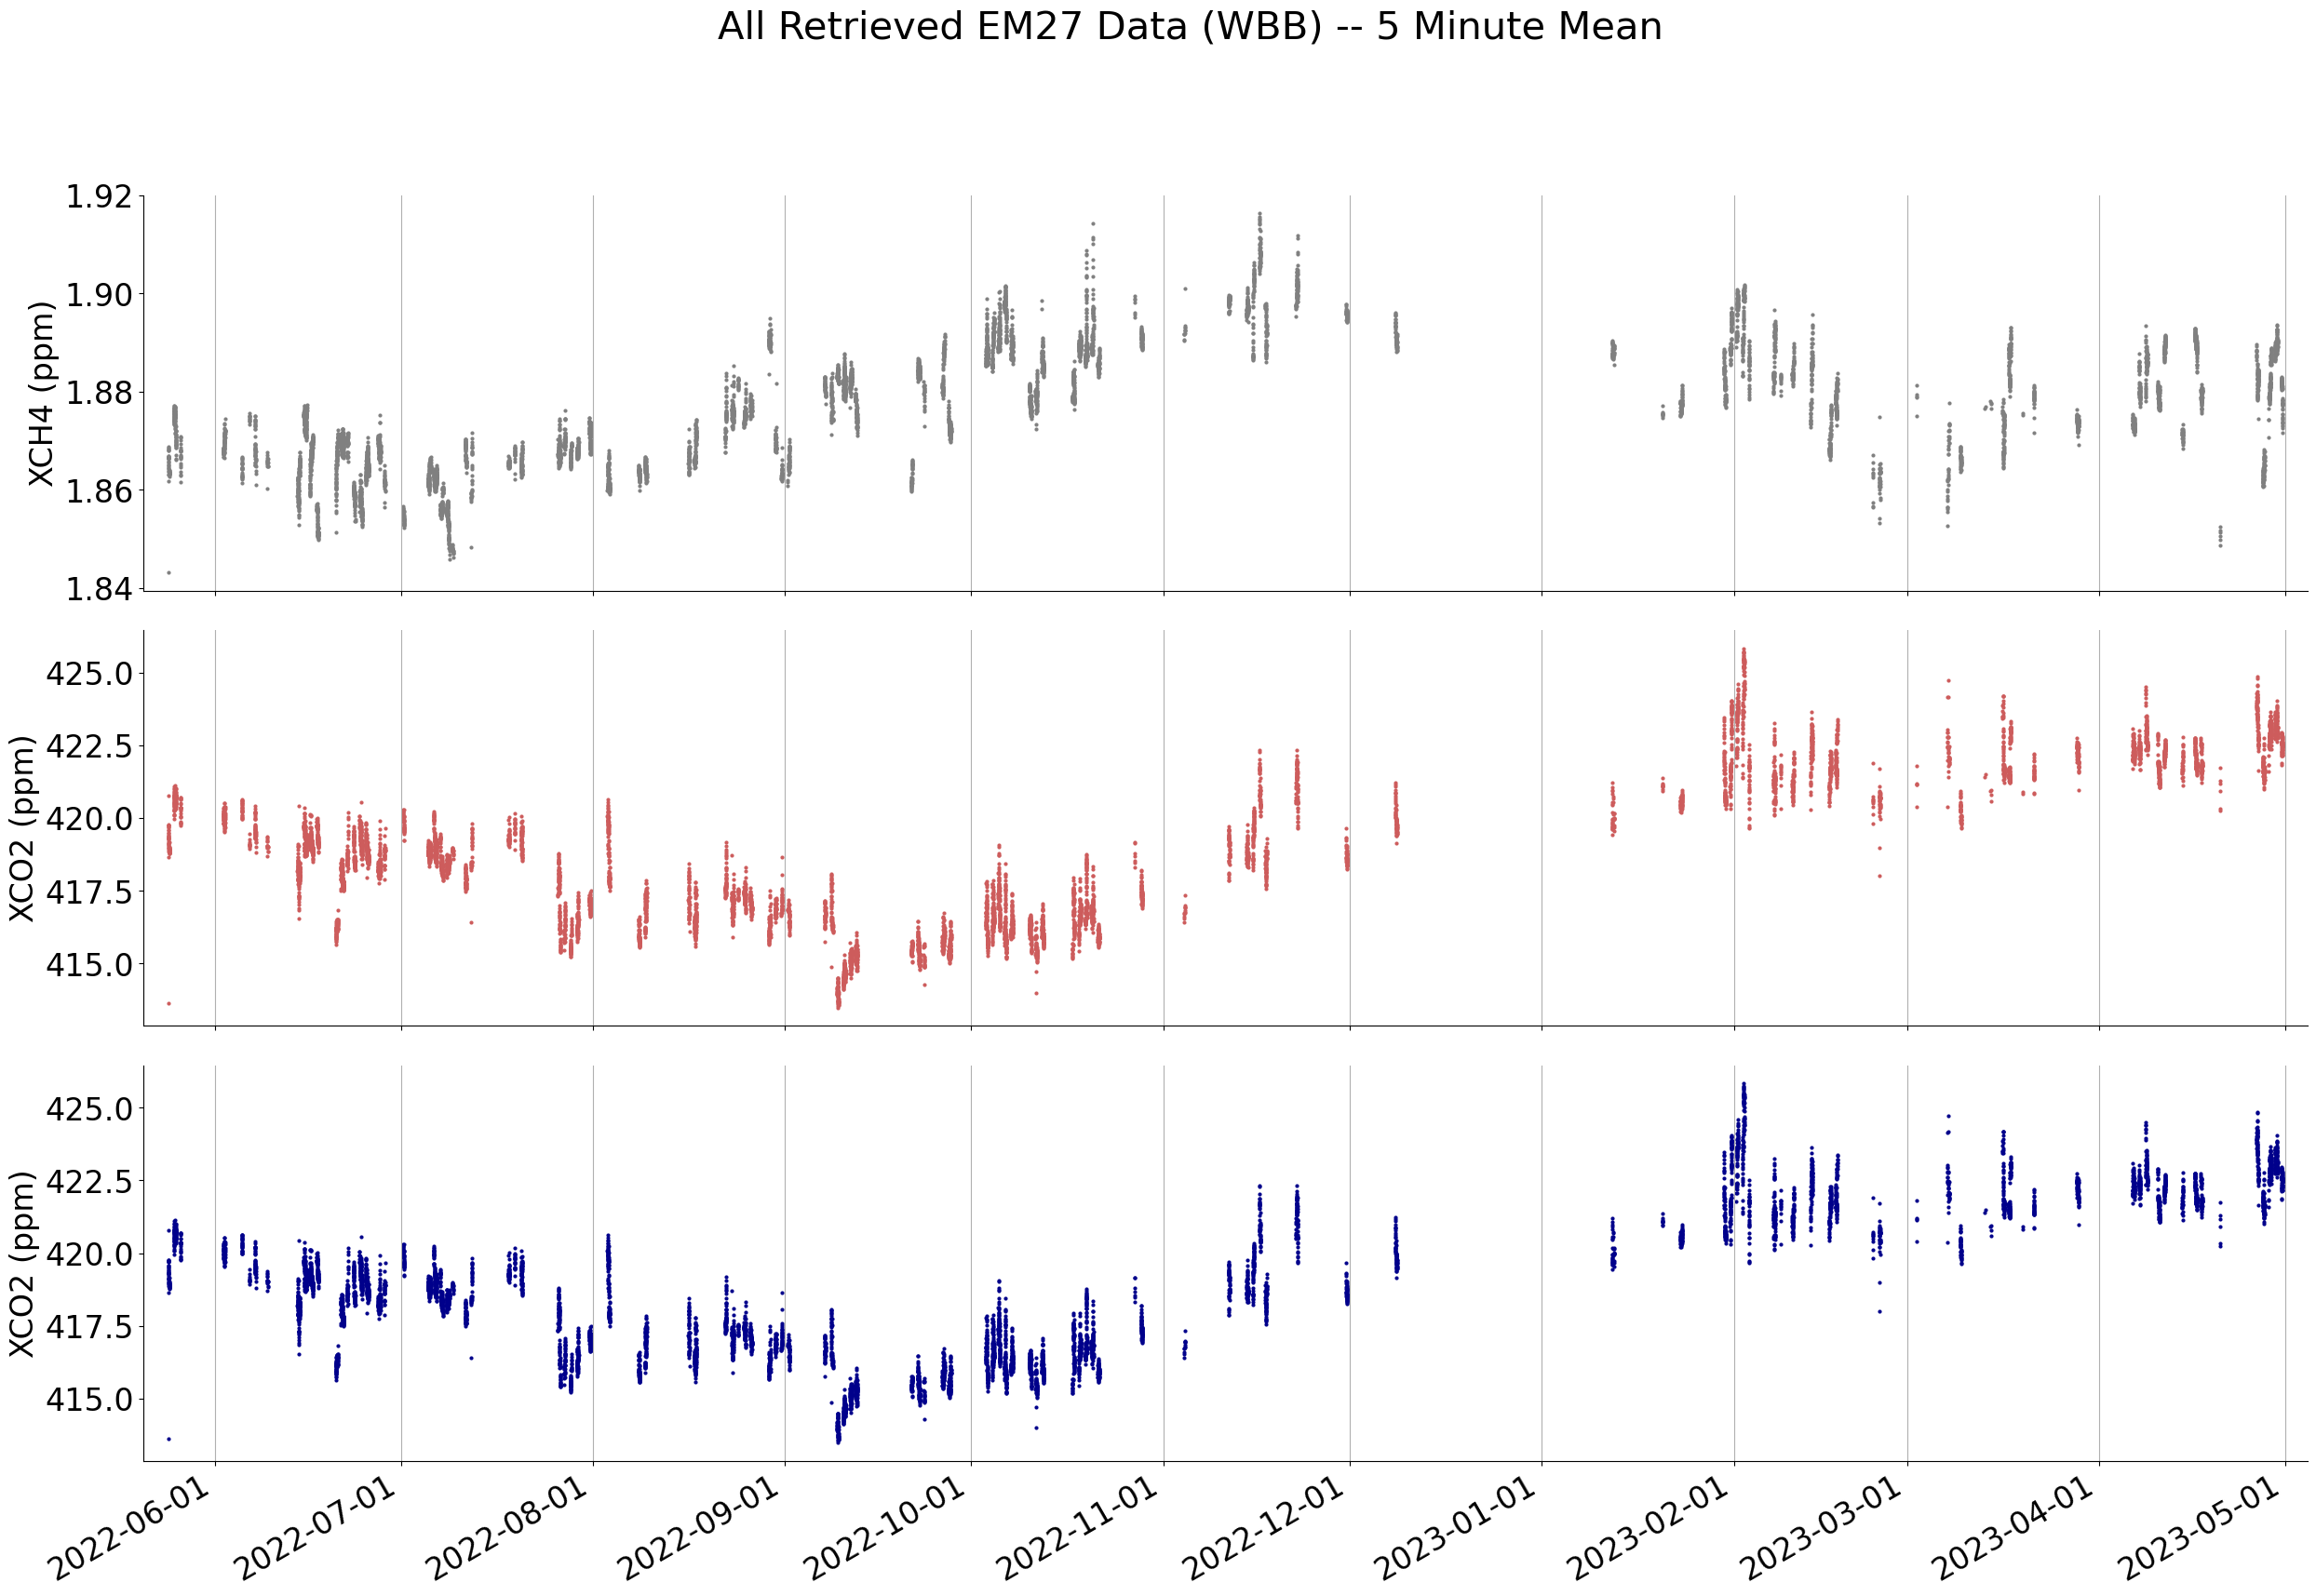

In [8]:
fig_id = 'CH4_CO2_all_WBB_ts'
savefig = True

fig,axes = plt.subplots(3,1,figsize = (30,20))
fig.suptitle('All Retrieved EM27 Data (WBB) -- 5 Minute Mean',fontsize = 30)
labsize = 24
marker_size = 4

xlims = [em27_resampled.index[0]-datetime.timedelta(days=4),em27_resampled.index[-1]+datetime.timedelta(days=4)]

axes[0].scatter(em27_resampled.index,em27_resampled['xch4(ppm)'],color = 'grey',s=marker_size)
axes[0].tick_params(labelsize = labsize)
axes[0].set_ylabel('XCH4 (ppm)',size = labsize)
axes[0].set_xlim(xlims)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].xaxis.grid(True)

axes[1].scatter(em27_resampled.index,em27_resampled['xco2(ppm)'],color = 'indianred',s=marker_size)
axes[1].tick_params(labelsize = labsize)
axes[1].set_ylabel('XCO2 (ppm)',size = labsize)
axes[1].set_xlim(xlims)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].xaxis.grid(True)

axes[2].scatter(em27_resampled.index,em27_resampled['xco2(ppm)'],color = 'darkblue',s=marker_size)
axes[2].tick_params(labelsize = labsize)
axes[2].set_ylabel('XCO2 (ppm)',size = labsize)
axes[2].set_xlim(xlims)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].xaxis.grid(True)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = em27_resampled.index.tz))

plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.show()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


# Interesting Days Finder

In [176]:
def plotly_em27_met(em27_df,met_df):
    #xlims = [em27_df.index[0]-datetime.timedelta(hours=1),em27_df.index[-1]+datetime.timedelta(hours=1)]
    xlims= [datetime.datetime.combine(em27_resampled.index[0].date(),datetime.time(hour=6)),
            datetime.datetime.combine(em27_resampled.index[-1].date(),datetime.time(hour=22))]
    fig = make_subplots(rows = 5,shared_xaxes=True,row_heights = [2,2,2,1,1],vertical_spacing=0.02)
    fig.add_trace(go.Scatter(
            x = em27_df.index,
            y = em27_df['xch4(ppm)'],
            error_y = dict(
                type='data', # value of error bar given in data coordinates
                array=em27_df['xch4(ppm)_error'],
                visible=True,
                color = 'grey',
                width = 0.5),
            mode='markers',
            marker={'color':'black'},
        ),row=1,col=1)
    fig.update_yaxes(row=1,col=1,title_text = 'XCH4 (ppm)')

    fig.add_trace(go.Scatter(
            x = em27_df.index,
            y = em27_df['xco2(ppm)'],
            error_y = dict(
                type='data', # value of error bar given in data coordinates
                array=em27_df['xco2(ppm)_error'],
                visible=True,
                color = 'grey',
                width = 0.5),
            mode='markers',
            marker={'color':'red'},
        ),row=2,col=1)
    fig.update_yaxes(row=2,col=1,title_text = 'XCO2 (ppm)')

    fig.add_trace(go.Scatter(
            x = em27_df.index,
            y = em27_df['xco(ppb)'],
            error_y = dict(
                type='data', # value of error bar given in data coordinates
                array=em27_df['xco(ppb)_error'],
                visible=True,
                color = 'grey',
                width = 0.5),
            mode='markers',
            marker={'color':'blue'}
        ),row=3,col=1)
    fig.update_yaxes(row=3,col=1,title_text = 'XCO (ppm)')

    fig.add_trace(go.Scatter(
            x = met_df.index,
            y = met_df['ws'],
            mode='markers',
            marker={'color':'black'}
        ),row=4,col=1)
    fig.update_yaxes(row=4,col=1,title_text = 'WS (m/s)')

    fig.add_trace(go.Scatter(
            x = met_df.index,
            y = met_df['wd'],
            mode='markers',
            marker={'color':'black'}
        ),row=5,col=1)
    fig.update_yaxes(row=5,col=1,title_text = 'WD (deg)')

    fig.update_layout(
        xaxis_range=xlims,
        height=800,
        #yaxis2 = dict(range=[10,90]),
        yaxis5 = dict(range=[0,360])
    )
    fig.update(layout_showlegend=False)
    fig.show()

In [177]:
em27_data_folder = "/Users/agmeyer4/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_oof_v2"

tz = 'US/Mountain'

oof_manage = ac.oof_manager(em27_data_folder,tz)
oof_files = oof_manage.get_sorted_oof()
oof_dates = [oof_manage.date_from_oof(fname) for fname in oof_files]

oof_dt_ranges = []
for oof_date in oof_dates:
    dt1_str = f"{oof_date.strftime('%Y-%m-%d')} 00:00:00"
    dt2_str = f"{oof_date.strftime('%Y-%m-%d')} 23:59:59"
    oof_dt_ranges.append({'dt1':oof_manage.tzdt_from_str(dt1_str),'dt2':oof_manage.tzdt_from_str(dt2_str)})

In [188]:
interesting_dtranges = {}
oof_dt_idx = -1

In [293]:
oof_dt_idx -= 5

In [304]:
oof_dt_idx += 1

dt_range = oof_dt_ranges[oof_dt_idx]
oof_manage = ac.oof_manager(em27_data_folder,tz)
flag0_em27_df = oof_manage.load_oof_df_inrange(dt_range['dt1'],dt_range['dt2'],True)

#Met data from WBB in situ
met_path = '/Users/agmeyer4/LAIR_1/Data/met/WBB.2023-02-03.csv'
met_df = pd.read_csv(met_path,header = 10,skiprows=[11])
met_df.index = pd.to_datetime(met_df['Date_Time']).dt.tz_convert(tz)
met_df = met_df.loc[(met_df.index>=dt_range['dt1'])&(met_df.index<=dt_range['dt2'])]
met_df[['u','v']] = met_df.apply(lambda row: ac.wdws_to_uv(row['wind_speed_set_1'],row['wind_direction_set_1']),axis = 1,result_type='expand')

em27_resample_interval = None
met_resample_interval = None

if em27_resample_interval == None:
    em27_resampled = flag0_em27_df.copy()
else:
    em27_resampled = flag0_em27_df.resample(em27_resample_interval).mean(numeric_only=True).dropna(how='all')

if met_resample_interval == None:
    met_resampled = met_df.copy()
else:
    met_resampled = met_df.resample(met_resample_interval).mean(numeric_only=True).dropna(how='all')
met_resampled['ws'],met_resampled['wd'] = np.vectorize(ac.uv_to_wdws)(met_resampled['u'],met_resampled['v'])

plotly_em27_met(em27_resampled,met_resampled)

IndexError: list index out of range

In [302]:
#Run this if the above is an interesting day. Will save (overwrite) the file, so be careful
comments = 'Coincident CH4, CO2, CO and wind speed/direction feature'

interesting_dtranges[dt_range['dt1'].strftime('%Y%m%d')] = {'dt_range':dt_range,
                                                             'comments':comments}

filename = 'interesting_dtrangedict_list.pkl'
with open(os.path.join(pickle_data_path,filename),'wb') as f:
    pickle.dump(interesting_dtranges,f)

# Interesting Days Figures

In [27]:
def mpl_interesting_plotter(em27_df,met_df,before_hours = 1,after_hours = 3):

    fig,axes = plt.subplots(5,1,figsize = (30,25),height_ratios=[2,2,2,1,1])
    labsize = 33

    em27_df_rolling = em27_df.rolling(datetime.timedelta(hours=1),center=True).mean()

    xlims = [em27_df.index[0]-datetime.timedelta(hours=before_hours),em27_df.index[-1]+datetime.timedelta(hours=after_hours)]

    species = 'xch4(ppm)'
    axes[0].scatter(em27_df.index,em27_df[species],color = 'grey',zorder=3,label='True Data Rate')
    axes[0].errorbar(em27_df.index,em27_df[species],
                    yerr=em27_df[f'{species}_error'],ls='none',
                    ecolor='grey',alpha=0.2)
    axes[0].plot(em27_df_rolling.index,em27_df_rolling[species],color='black',zorder=4,label='1H Rolling Mean')
    axes[0].tick_params(labelsize = labsize)
    axes[0].set_ylabel(species,size = labsize)
    axes[0].set_xlim(xlims)
    axes[0].xaxis.grid(True)
    axes[0].legend(fontsize = labsize *0.8)

    species = 'xco2(ppm)'
    axes[1].scatter(em27_df.index,em27_df[species],color = 'indianred',zorder=3)
    axes[1].errorbar(em27_df.index,em27_df[species],
                    yerr=em27_df[f'{species}_error'],ls='none',
                    ecolor='grey')
    axes[1].plot(em27_df_rolling.index,em27_df_rolling[species],color='darkred',zorder=4)
    axes[1].tick_params(labelsize = labsize)
    axes[1].set_ylabel(species,size = labsize)
    axes[1].set_xlim(xlims)
    axes[1].xaxis.grid(True)
    axes[1].plot([],[],alpha = 0,label=f"{fill(interesting['comments'], 20)}")
    leg = axes[1].legend(fontsize = labsize*0.7)
    leg.set_title('Comments',prop={'size':labsize})


    species = 'xco(ppb)'
    axes[2].scatter(em27_df.index,em27_df[species],color = 'dodgerblue',zorder=3)
    axes[2].errorbar(em27_df.index,em27_df[species],
                    yerr=em27_df[f'{species}_error'],ls='none',
                    ecolor='grey')
    axes[2].plot(em27_df_rolling.index,em27_df_rolling[species],color='darkblue',zorder=4)
    axes[2].tick_params(labelsize = labsize)
    axes[2].set_ylabel(species,size = labsize)
    axes[2].set_xlim(xlims)
    axes[2].xaxis.grid(True)


    axes[3].scatter(met_df.index,met_df['ws'],color = 'black')
    axes[3].tick_params(labelsize = labsize)
    axes[3].set_ylabel('ws (m/s)',size = labsize)
    axes[3].set_xlim(xlims)
    axes[3].xaxis.grid(True)

    # axes[3].spines['top'].set_visible(False)
    # axes[3].spines['right'].set_visible(False)

    axes[4].scatter(met_df.index,met_df['wd'],color = 'black')
    axes[4].set_yticks([0,90,180,270,360])
    axes[4].tick_params(labelsize = labsize)
    axes[4].set_ylabel('wd',size = labsize)
    axes[4].set_xlim(xlims)
    axes[4].xaxis.grid(True)
    # axes[4].spines['top'].set_visible(False)
    # axes[4].spines['right'].set_visible(False)

    axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %Z', tz = em27_df.index.tz))
    axes[4].set_xlabel(em27_df.index[0].strftime('%b %d, %Y'),size = labsize)

    plt.subplots_adjust(hspace=0.2)
    plt.gcf().autofmt_xdate()

    plt.show()
    return fig


In [28]:
# Interesting dates from saved picklefile
filename = 'interesting_dtrangedict_list.pkl'
with open(os.path.join(pickle_data_path,filename),'rb') as f:
    interesting_dtranges = pickle.load(f)

em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"
tz = 'US/Mountain'

In [29]:
interesting_dates_list = list(interesting_dtranges.keys())
interesting_dates_idx = 1

In [30]:
interesting_dates_idx -= 3


In [34]:
interesting_dates_idx = 9
interesting_date = interesting_dates_list[interesting_dates_idx]
interesting = interesting_dtranges[interesting_date]

dt_range = interesting['dt_range']


oof_manage = ac.oof_manager(em27_data_folder,tz)
flag0_em27_df = oof_manage.load_oof_df_inrange(dt_range['dt1'],dt_range['dt2'],True)

#Met data from WBB in situ
met_path = '~/LAIR_1/Data/met/WBB.2023-02-03.csv'
met_df = pd.read_csv(met_path,header = 10,skiprows=[11])
met_df.index = pd.to_datetime(met_df['Date_Time']).dt.tz_convert(tz)
met_df = met_df.loc[(met_df.index>=dt_range['dt1'])&(met_df.index<=dt_range['dt2'])]
met_df[['u','v']] = met_df.apply(lambda row: ac.wdws_to_uv(row['wind_speed_set_1'],row['wind_direction_set_1']),axis = 1,result_type='expand')

em27_resample_interval = None
met_resample_interval = None

if em27_resample_interval == None:
    em27_resampled = flag0_em27_df.copy()
else:
    em27_resampled = flag0_em27_df.resample(em27_resample_interval).mean(numeric_only=True).dropna(how='all')

if met_resample_interval == None:
    met_resampled = met_df.copy()
else:
    met_resampled = met_df.resample(met_resample_interval).mean(numeric_only=True).dropna(how='all')
met_resampled['ws'],met_resampled['wd'] = np.vectorize(ac.uv_to_wdws)(met_resampled['u'],met_resampled['v'])

/scratch/local/u0890904/12763222/ipykernel_1238345/3442946173.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['spectrum'], dtype='object')
  em27_df_rolling = em27_df.rolling(datetime.timedelta(hours=1),center=True).mean()


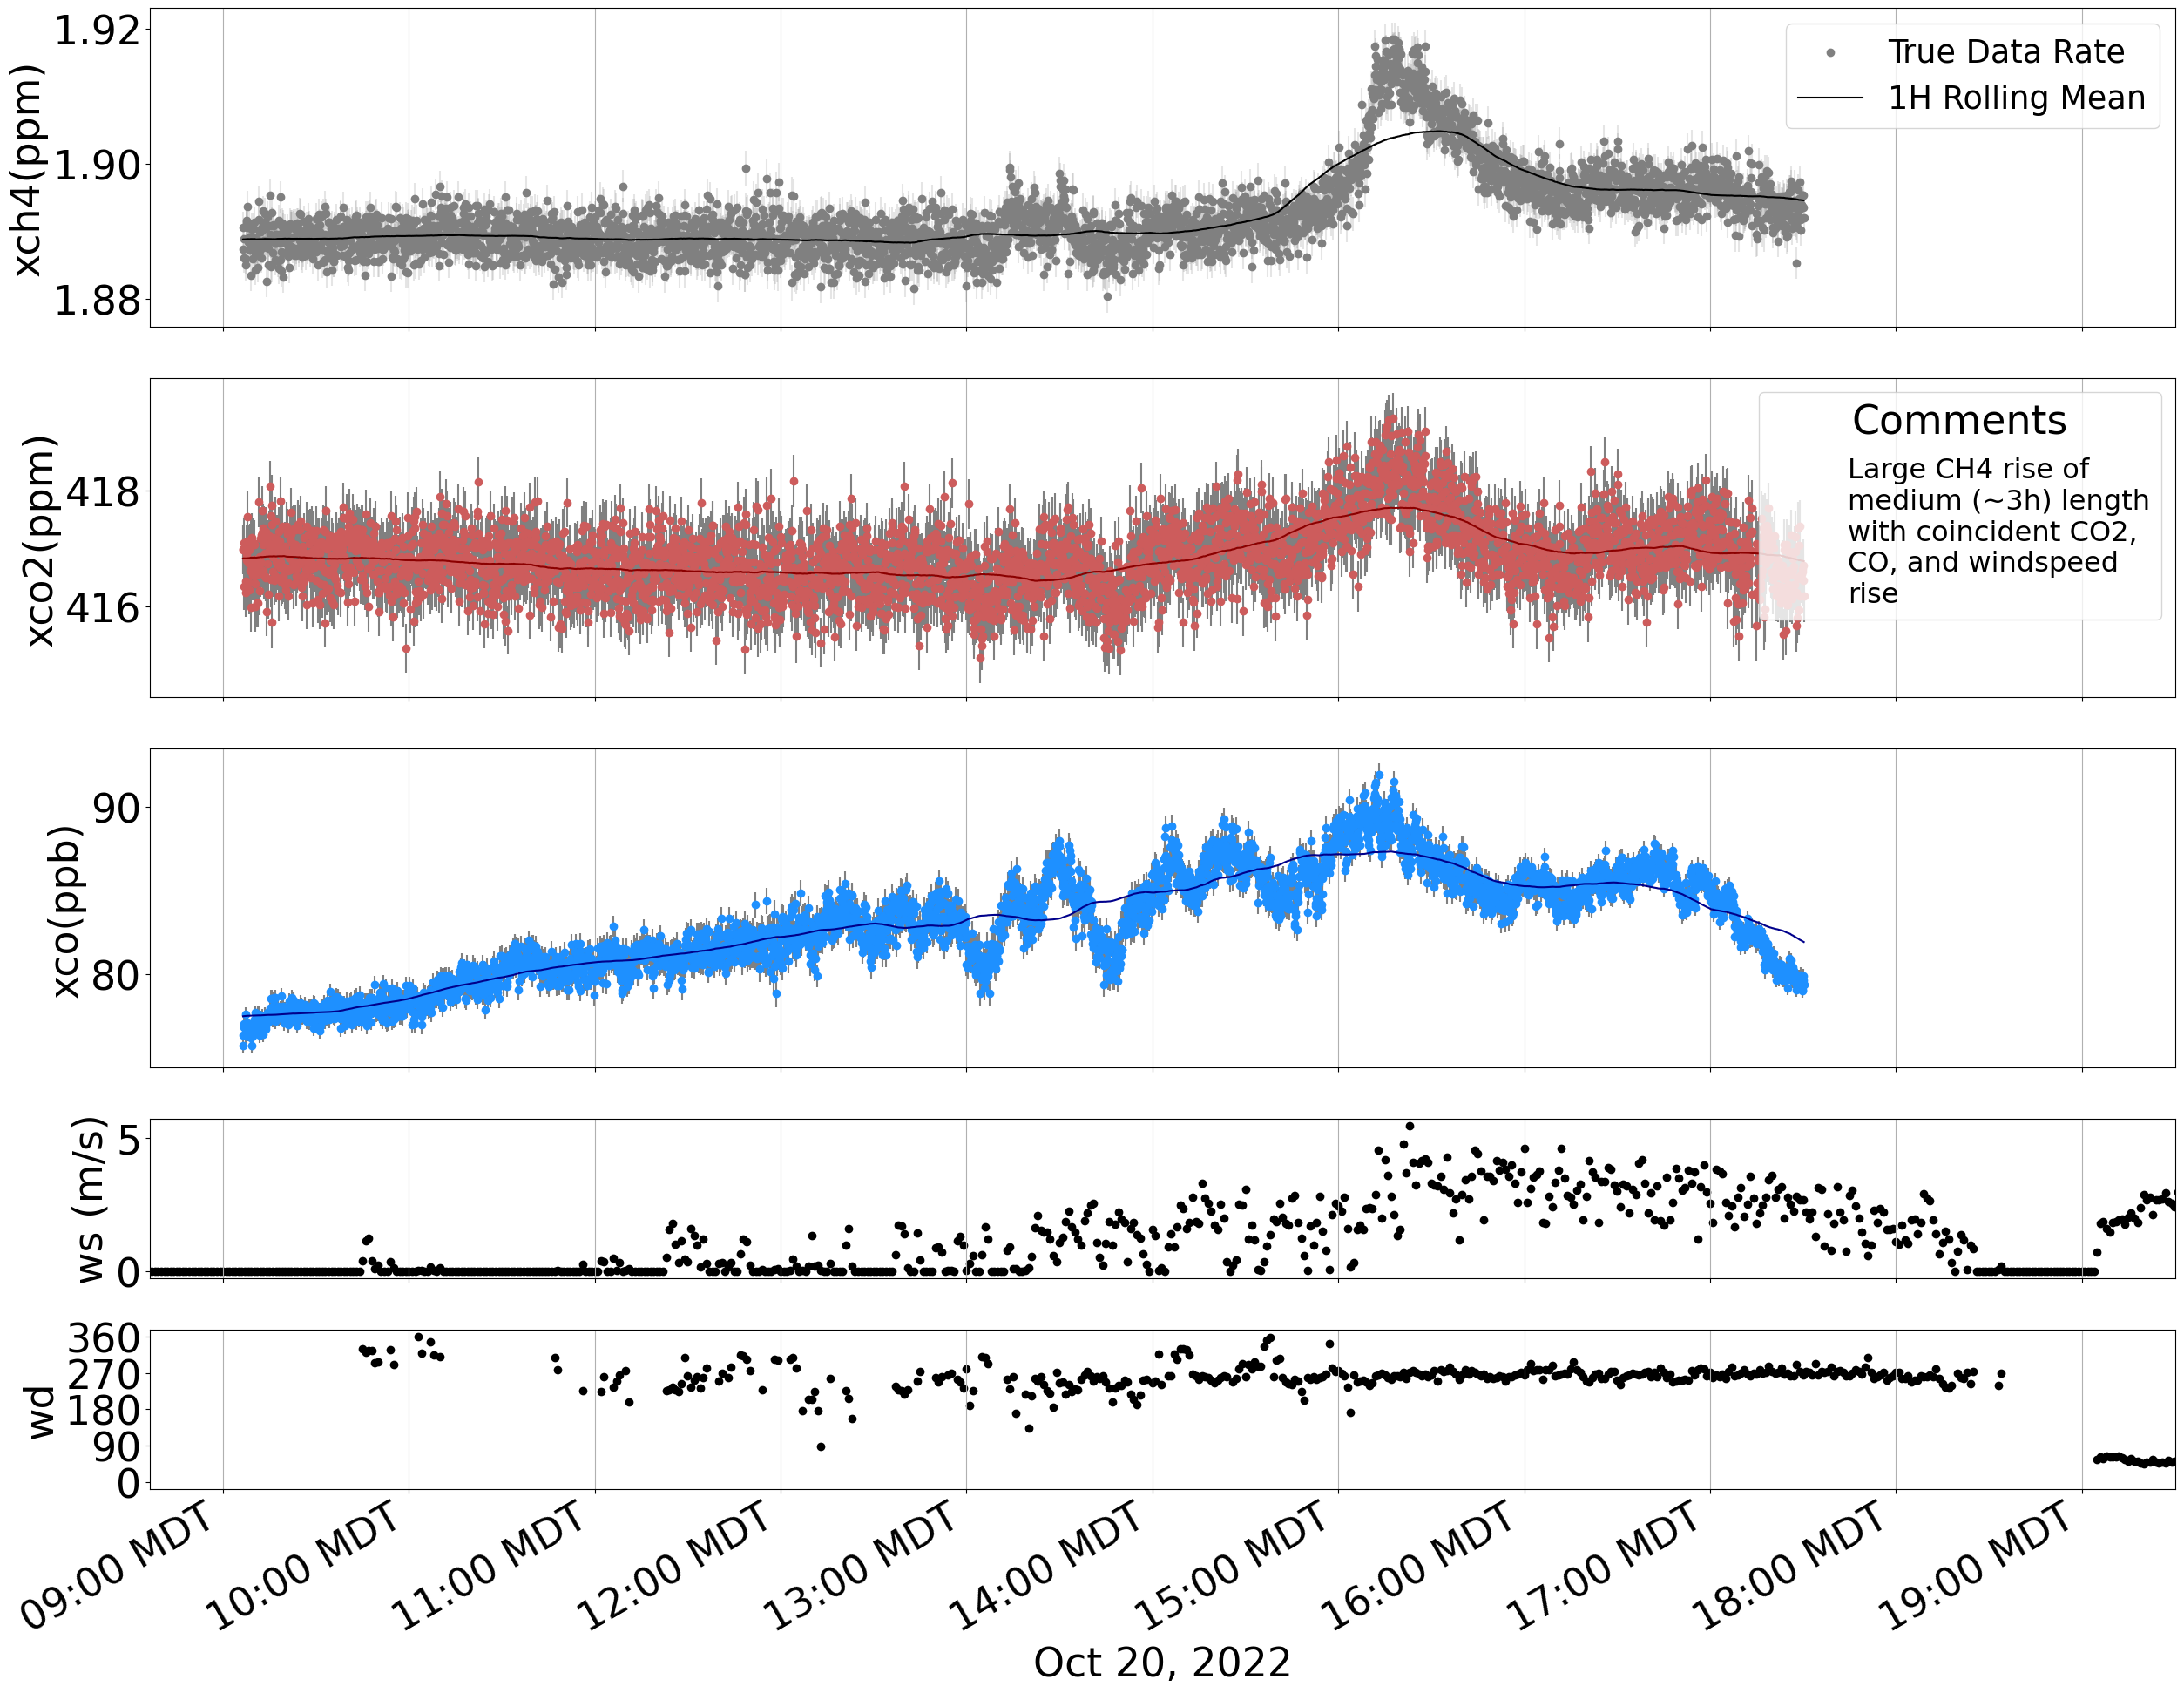

In [35]:
fig = mpl_interesting_plotter(em27_resampled,met_resampled,before_hours = 0.5,after_hours = 2)

In [36]:
figname = f"{interesting_date}_interesting.png"
fig.savefig(os.path.join(figures_path,figname))